In [144]:
import dask
from dask.distributed import Client
import dask_jobqueue
import discretize
from discretize.utils import mkvc
# import deepdish as dd
import h5py
import json
import matplotlib.pyplot as plt
from matplotlib import cm as cmap
from matplotlib.colors import LogNorm, Normalize
import numpy as np
import os
import pandas as pd
import scipy.sparse as sp
import xarray as xr
import zarr

import casingSimulations as casing_sim
from SimPEG import maps
from SimPEG.electromagnetics import time_domain as tdem
from pymatsolver import Pardiso

np.random.seed(29)

In [2]:
directory = "test"

if not os.path.isdir(directory):
    os.makedirs(directory, exist_ok=True)

In [3]:
from matplotlib import rcParams
rcParams["font.size"] = 16

In [4]:
nsamples = 2

In [5]:
# set bounds for the distributions of 
sigma_background_bounds = np.r_[1e-4, 1]
sigma_casing_bounds = np.r_[1e4, 1e7]

d_casing_bounds = np.r_[5e-2, 30e-2]
t_casing_bounds = np.r_[0.5e-2, 2e-2]
l_casing_bounds = np.r_[20, 4e3]

In [6]:
# constants
sigma_air = 1e-4
sigma_inside = 1  # fluid inside the casing
mur_casing = 1  # permeability is the same as free space

src_a = np.r_[0., 0., 0.]  # the radius will be updated to connect to the casing
src_b = np.r_[1000., 0, 0]

csz = 2.5  # cell-size in the z-direction
hy = np.ones(12)
hy = hy*2*np.pi / hy.sum()

In [7]:
# areas to compare data

z_compare = np.linspace(-100, 0, 128)

In [8]:
def generate_random_variables(bounds, n_samples, sig_digs=None):
    min_value = bounds.min()
    max_value = bounds.max()
    v = np.random.rand(n_samples)
    v = min_value + (v*(max_value - min_value))
    if sig_digs is not None:
        v = np.round((v*10**(sig_digs)))/10**(sig_digs)
    return v

In [9]:
log10_sigma_background_dist = generate_random_variables(np.log10(sigma_background_bounds), nsamples, 2)
log10_sigma_casing_dist = generate_random_variables(np.log10(sigma_casing_bounds), nsamples, 2)

d_casing_dist = generate_random_variables(d_casing_bounds, nsamples, 2) 
t_casing_dist = generate_random_variables(t_casing_bounds, nsamples, 2) 
l_casing_dist = np.r_[100, 100]  #generate_random_variables(l_casing_bounds/csz, nsamples, 0) * csz # generate by ncells

parameters = {
    "log10_sigma_background":log10_sigma_background_dist,
    "log10_sigma_casing":log10_sigma_casing_dist,
    "d_casing":d_casing_dist,
    "t_casing":t_casing_dist,
    "l_casing":l_casing_dist,
}

In [10]:
df = pd.DataFrame(parameters)
df

,log10_sigma_background,log10_sigma_casing,d_casing,t_casing,l_casing
0,-0.54,4.22,0.16,0.02,100
1,-2.86,6.29,0.19,0.02,100


In [11]:
df.shape

(2, 5)

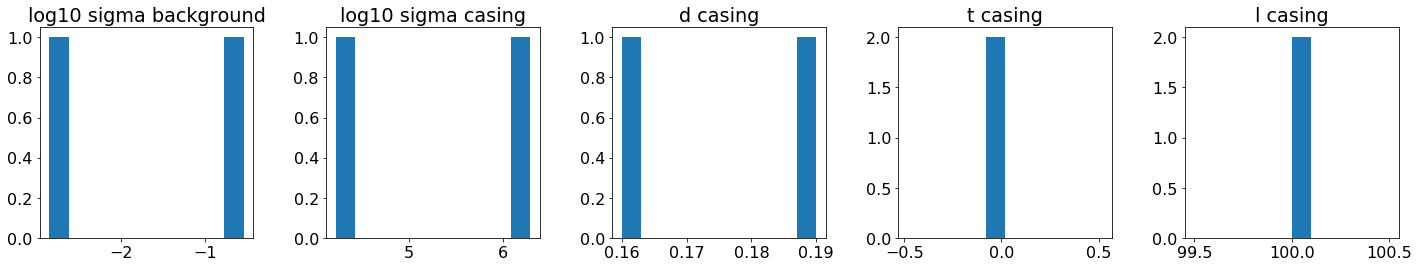

In [12]:
fig, ax = plt.subplots(1,5, figsize=(20, 4))

for i, key in enumerate(parameters.keys()):
    ax[i].hist(df[key])
    ax[i].set_title(f"{key}".replace("_", " "))

plt.tight_layout()

In [13]:
parameters["l_casing"]

array([100, 100])

In [14]:
time_steps = [
    (1e-6, 20), (1e-5, 30), (3e-5, 30), (1e-4, 40), (3e-4, 30), (1e-3, 20), (1e-2, 15)
]

In [15]:
i = 0

[df.loc[i].to_hdf(f"{directory}/trial_{i}.h5", key) for key in df.loc[i].keys()]

trial_directory = f"{directory}/trial_{i}/"
if not os.path.isdir(trial_directory):
    os.makedirs(trial_directory, exist_ok=True)
    df.loc[i].

cd = parameters["d_casing"][i]
ct = parameters["t_casing"][i]
cl = parameters["l_casing"][i]

sc = 10**(parameters["log10_sigma_casing"][i])
sb = 10**(parameters["log10_sigma_background"][i])



In [16]:
model = casing_sim.model.CasingInHalfspace(
    directory=trial_directory,
    casing_d = cd - ct,  # I use diameter to the center of the casing wall
    casing_l = cl,
    casing_t = ct, 
    mur_casing = mur_casing,
    sigma_air = sigma_air,
    sigma_casing = sc,
    sigma_back = sb,
    sigma_inside = sb,
    src_a = src_a,
    src_b = src_b,
    timeSteps = time_steps
)
model.filename = "casing.json"

np.sum(model.timeSteps)

0.18422000000000002

In [17]:
sigmaA = model.sigma_casing * (model.casing_b**2 - model.casing_a**2)/model.casing_b**2
print(f"The approximate conductivity of the solid we use is {sigmaA:1.1e}")

model_approx_casing = model.copy()
model_approx_casing.sigma_inside = sigmaA
model_approx_casing.sigma_casing = sigmaA
model_approx_casing.filename = "approx_casing.json"

The approximate conductivity of the solid we use is 7.3e+03


In [18]:
meshGen = casing_sim.mesh.CasingMeshGenerator(
    modelParameters = model, 
    csx1 = model.casing_t/4,
    csx2 = 100,
    domain_x = cl,  # use 2.5m cells out to 300m. 
    hy = hy,
    npadx = 8, # 6
    npadz = 17,  #14
    csz = csz,
)
mesh = meshGen.mesh

742.8652886064586


/global/homes/l/lheagy/.conda/envs/simpeg37/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


(0, 1100)

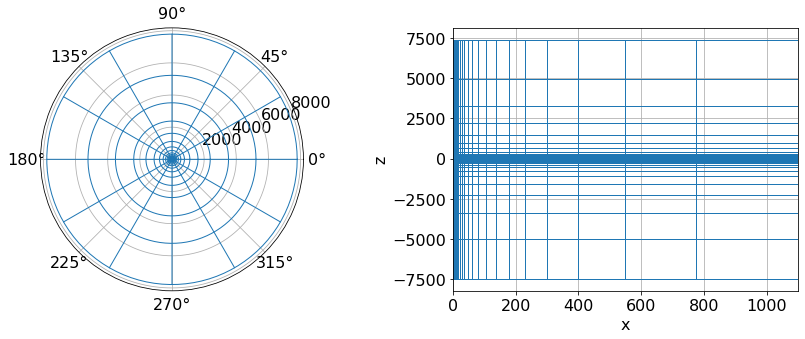

In [19]:
print(model.diffusion_distance(t=0.1))
ax = mesh.plotGrid()

ax[1].set_xlim([0, 1100])

In [20]:
src_theta = np.pi/2. + mesh.hy[0]/2.
model.src_a[1] = src_theta
model.src_b[1] = src_theta


In [21]:
src_top = casing_sim.sources.TopCasingSrc(
    modelParameters=model, 
    meshGenerator=meshGen,
    src_a=model.src_a,
    src_b=model.src_b,
    physics="TDEM",
    filename="top_casing",
)

source_list = src_top.srcList

In [22]:
model.sigma(mesh)

array([2.8840315e-01, 2.8840315e-01, 2.8840315e-01, ..., 1.0000000e-04,
       1.0000000e-04, 1.0000000e-04])

In [23]:
np.save(f"{trial_directory}casing.npy", model.sigma(mesh))
np.save(f"{trial_directory}approx_casing.npy", model_approx_casing.sigma(mesh))

In [24]:
survey = tdem.Survey(source_list)

In [25]:
sim = tdem.Problem3D_j(
    mesh=mesh, survey=survey, solver=Pardiso,
    time_steps=time_steps
)

# dd.io.save(f"{trial_directory}simulation.h5", sim.serialize())

with open(f"{trial_directory}simulation.json", 'w') as outfile:
    json.dump(sim.serialize(), outfile)

In [26]:
def compute_fields(model, trial_directory):
    import deepdish as dd
    import discretize
    import casingSimulations as casing_sim
    from SimPEG.electromagnetics import time_domain as tdem
    from SimPEG import maps
    from pymatsolver import Pardiso
    
#     simulation_params = dd.io.load(f"{trial_directory}simulation.h5")
#     print(f"{trial_directory}simulation.json")
    with open(f"{trial_directory}simulation.json") as f:
        simulation_params = json.load(f)
    sim = tdem.Problem3D_j.deserialize(simulation_params, trusted=True)
    sim.solver = Pardiso
    sim.sigmaMap=maps.IdentityMap(mesh)
    sim.verbose=True
    
    m = np.load(f"{trial_directory}{model}.npy")
    fields = sim.fields(m)
    f = fields[:, '{}Solution'.format(sim._fieldType), :]
 
    filename = f"{model}_fields.npy"
    tosave = os.path.sep.join([trial_directory, filename]) 
    print(f"saving {tosave}")
    np.save(tosave, f)
    
    return tosave

In [57]:
cluster = dask_jobqueue.SLURMCluster(
    cores=1,
    processes=2, memory='120GB', 
    job_cpu=1,
    project="m3384",
    job_extra = ['--constraint=haswell', '--qos=debug',], 
    death_timeout=360,
)

print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -A m3384
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=112G
#SBATCH -t 00:30:00
#SBATCH --constraint=haswell
#SBATCH --qos=debug
JOB_ID=${SLURM_JOB_ID%;*}



/global/homes/l/lheagy/.conda/envs/simpeg37/bin/python -m distributed.cli.dask_worker tcp://128.55.224.44:43825 --nthreads 0 --nprocs 2 --memory-limit 60.00GB --name dask-worker--${JOB_ID}-- --death-timeout 360



/global/homes/l/lheagy/.conda/envs/simpeg37/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [58]:
client = Client(cluster)
client

Client Scheduler: tcp://128.55.224.44:43825 Dashboard: http://128.55.224.44:44657/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [63]:
f = {}
for m in ["casing", "approx_casing"]:
#     f[m] = compute_fields(m, trial_directory)
    f[m] = dask.delayed(compute_fields)(m, trial_directory)

In [64]:
cluster.scale(1)

In [65]:
fields_files = dask.compute(f)[0]

In [27]:
ndata = 32
ntimes = 128
xsample = np.linspace(5, 1000, ndata)
zsample = np.linspace(-cl, 0, ndata)
xz_grid = discretize.utils.ndgrid(xsample, np.r_[0], zsample)
tsample = np.logspace(-6, -2, 128)

In [28]:
currents = {}
for m in ["casing", "approx_casing"]:
    currents[m] = np.load(f"{trial_directory}{m}_fields.npy")

In [29]:
# compute jd
jd = currents["casing"] - currents["approx_casing"]

In [30]:
jdx = mkvc(jd[:mesh.vnF[0], :]).reshape(tuple(mesh.vnFx)+(sim.nT+1,), order="F")
jdz = mkvc(jd[np.sum(mesh.vnF[:2]):, :]).reshape(tuple(mesh.vnFz)+(sim.nT+1,), order="F")

# take mean in theta-dimension jdx.mean(1)
jdx = jdx.mean(1)
jdz = jdz.mean(1)

jdxz = np.hstack([mkvc(jdx), mkvc(jdz)])

In [37]:
# build projection matrices for data 
mesh2d = discretize.CylMesh([mesh.hx, 1, mesh.hz], x0=mesh.x0)
Px = mesh2d.getInterpolationMat(xz_grid, 'Fx')
Pz = mesh2d.getInterpolationMat(xz_grid, 'Fz')
Pt = sim.time_mesh.getInterpolationMat(tsample, 'N')

Pxt = sp.kron(Pt, Px)
Pzt = sp.kron(Pt, Pz)
P = sp.vstack([Pxt, Pzt])

jdata = P * jdxz
np.save(f"{trial_directory}j_difference.npy")

In [95]:
# compute current inside casing
ind_casing = model.ind_casing(mesh) + model.ind_inside(mesh)
ind_casing_Fz = (mesh.aveFz2CC.T * ind_casing).astype(bool)

I = discretize.utils.sdiag(mesh.area) * currents["approx_casing"]
Iz = I[mesh.vnF[:2].sum():, :]
Iz[~ind_casing_Fz, :] = 0


In [96]:
Iz = Iz.reshape(tuple(mesh.vnFz) + (sim.nT+1,), order="F")

In [98]:
Iz_casing = (Iz.sum(0)).sum(0)

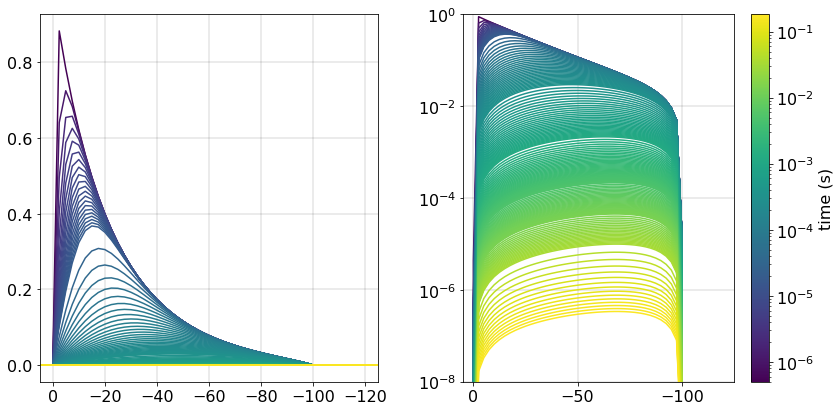

In [157]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

cm = plt.get_cmap('viridis')
c_norm = LogNorm(vmin=sim.timeMesh.vectorCCx[0], vmax=sim.timeMesh.vectorNx[-1])
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

for i in range(sim.nT):
    ax[0].plot(mesh.vectorNz, -Iz_casing[:, i], color=scalar_map.to_rgba(sim.timeMesh.vectorNx[i]+1e-7))
    ax[1].semilogy(mesh.vectorNz, np.abs(-Iz_casing[:, i]), color=scalar_map.to_rgba(sim.timeMesh.vectorNx[i]+1e-7))

for a in ax:
    a.set_xlim([5., -1.25*model.casing_l])
    a.grid(which="both", color="k", lw=0.4, alpha=0.4)

ax[1].set_ylim([1e-8, 1])

cb = plt.colorbar(scalar_map)
cb.set_label("time (s)")
plt.tight_layout()

/global/homes/l/lheagy/.conda/envs/simpeg37/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  # Remove the CWD from sys.path while we load stuff.


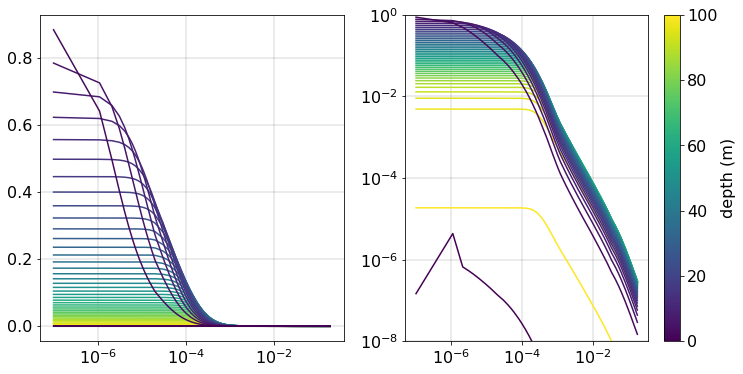

In [159]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

cm = plt.get_cmap('viridis')
c_norm = Normalize(vmin=0, vmax=model.casing_l)
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

for i in range(mesh.vnFz[2]):
    ax[0].semilogx(sim.timeMesh.vectorNx+1e-7, -Iz_casing[i, :], color=scalar_map.to_rgba(-mesh.vectorNz[i]))
    ax[1].loglog(sim.timeMesh.vectorNx+1e-7, np.abs(-Iz_casing[i, :]), color=scalar_map.to_rgba(-mesh.vectorNz[i]))

for a in ax:
#     a.set_xlim([5., -1.25*model.casing_l])
    a.grid(which="both", color="k", lw=0.4, alpha=0.4)

ax[1].set_ylim([1e-8, 1])

cb=plt.colorbar(scalar_map)
cb.set_label("depth (m)")


In [164]:
n_z_currents = 128
z_sample = np.linspace(-model.casing_l, 0, n_z_currents)
Pz_casing_currents = discretize.TensorMesh([mesh.hz], [mesh.x0[2]]).getInterpolationMat(
    z_sample, 'N'
)

In [167]:
P_casing_currents = sp.kron(Pt, Pz_casing_currents)
I_casing_data = -1*P_casing_currents*discretize.utils.mkvc(Iz_casing)
np.save(f"{trial_directory}casing_currents.npy", I_casing_data)